# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

In [2]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
portfolio.id.nunique()

10

As seen there are 10 different types of offers disbursed to the customers by starbucks

In [6]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

There are three types of offers : BOGO, discount & informational.

In the feature engineering step we will convert the channels column into one-hot encoded feature.

In [7]:
##converting column id to offer_id

portfolio.rename(columns={'id':'offer_id'}, inplace=True)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


# Profile Dataset

Contains information about customers i.e. Demographic Data

In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [10]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

We can see that there are Null values in gender and income column. On further investigation it was found that its the same records, so we discard them.

In [11]:
#Age Column
profile[profile.age == 118][['gender','age','income']]

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
9,None,118,NaN
10,None,118,NaN
11,None,118,NaN
17,None,118,NaN
23,None,118,NaN


In [12]:
profile.id.nunique()

17000

In [13]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

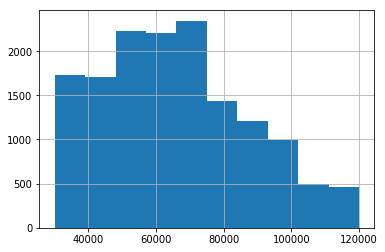

In [14]:
profile.income.hist()

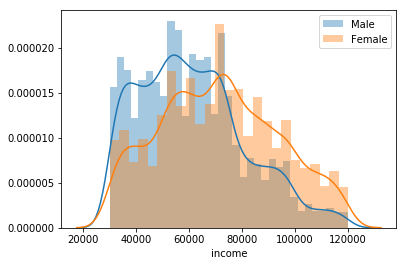

In [15]:
#Gender-Wise Income distribution
sns.distplot(profile[profile.gender == 'M'].income, label = 'Male')
sns.distplot(profile[profile.gender == 'F'].income, label = 'Female')
plt.legend()
plt.show()

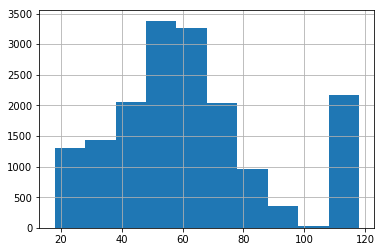

In [16]:
#Age Distribution
profile.age.hist()

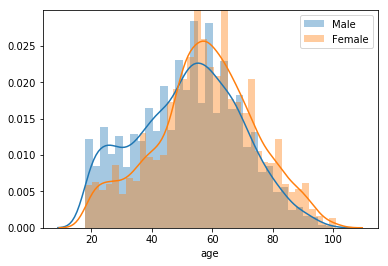

In [17]:
#Gender-wise age distribution
sns.distplot(profile[profile.gender == 'M'].age, label = 'Male')
sns.distplot(profile[profile.gender == 'F'].age, label = 'Female')
plt.legend()
plt.show()

The "became_member_on_columns" can be feature engineered to get the tenure of membership in days

In [18]:
profile.became_member_on.head()

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

# Transcript Dataset

It stores information about events in a timeline

In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


This data looks tricky as its ordered by time and has an event and value. Value column will have to be processed depending on event.

In [20]:
#Quick check on missing value
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

No null values

In [21]:
#Event Distribution
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [22]:
#Extract different values in value column out
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis =1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


We have to clean data to have one offer_id columns

In [23]:
#Clean up duplicates in offer_id
transcript['clean_id'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(), transcript['offer_id'], transcript['offer id'])

#drop original id column
transcript.drop(['offer id','offer_id'], axis =1 , inplace = True)

#rename offer id column
transcript.rename(columns={'clean_id':'offer_id'}, inplace=True)

In [24]:
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [25]:
transcript.offer_id.nunique()

10

In [26]:
transcript.person.nunique()

17000

Number of people in transcript are same as the number of people in Demographics data

In [27]:
temp = pd.merge(transcript, portfolio, how='left',on='offer_id')
temp.head()

,event,person,time,value,amount,reward_x,offer_id,channels,difficulty,duration,offer_type,reward_y
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,bogo,10.0


In [28]:
temp.groupby(['offer_type','event']).person.count()

offer_type     event          
bogo           offer completed    15669
               offer received     30499
               offer viewed       25449
discount       offer completed    17910
               offer received     30543
               offer viewed       21445
informational  offer received     15235
               offer viewed       10831
Name: person, dtype: int64

We can observe that informational offer type doesnt have offer completed event and hence transaction can be considered as the offer completed event.

# Defining approach for preprocessing

The first objective in data preprocessing is to define a methodology to assign offer_ids to specific transactions.

BOGO and discount offers have a completed event when offers are completed. But informational offers do not have this event associated with it.


In [29]:
transcript = transcript.merge(portfolio, how='left', on ='offer_id')
transcript.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

# Data Preprocessing

Assign offer_ids to transactions. 

Define customer into 4 groups:

- People who are influenced and successfully complete - effective orders
- People who received and viewed an offer but did not successfully complete - ineffective orders
- People who purchase/complete offers regardless of awareness of any offers
- People who received offers but no action taken

In [30]:
#drop useless columns
transcript_processed = pd.DataFrame(transcript)

transcript_processed = transcript_processed.drop(columns = ['reward_x','reward_y'], axis=1, inplace=False)
transcript_processed.head()

,event,person,time,value,amount,offer_id,channels,difficulty,duration,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,bogo
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,bogo


In [31]:
#sort events by person and time
transcript_processed = transcript_processed.sort_values(['person','time'])
transcript_processed.head(5)

,event,person,time,value,amount,offer_id,channels,difficulty,duration,offer_type
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational


In [32]:
#filter dataset for transactions that occur after an offer is viewed, forward fill offer ids by person
offer_completed = transcript_processed[['time','offer_id','person','event']][(transcript_processed['event']=='transaction') | (transcript_processed['event']=='offer viewed')]
offer_completed.update(offer_completed.groupby(['person']).ffill())
offer_completed['offer_id'] = offer_completed['offer_id'].ffill()


In [33]:
transcript_processed = transcript_processed.merge(offer_completed, how='left', on =['person','time','event'])
transcript_processed.head()

,event,person,time,value,amount,offer_id_x,channels,difficulty,duration,offer_type,offer_id_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed


In [34]:
#clean up dataframe
transcript_processed['offer_id'] = np.where(transcript_processed['offer_id_x'].isnull(),transcript_processed['offer_id_y'],transcript_processed['offer_id_x'])
transcript_processed.drop(columns=['offer_id_x','offer_id_y'],axis=1, inplace=True)

In [35]:
#merge portfolio dataset to offer
transcript_processed= transcript_processed.merge(portfolio, how='left', on = 'offer_id')
transcript_processed['duration'] = np.where(transcript_processed['duration_x'].isnull(),transcript_processed['duration_y'],transcript_processed['duration_x'])
transcript_processed.drop(columns=['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],axis=1, inplace=True)
transcript_processed.rename(columns={'channels_y':'channels','reward_y':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)


In [36]:
transcript_processed.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0


Flagging transactions and offers completed after offers viewed

In [37]:
#subset data with only offer viewed, transaction and offer completed events
transactions_after_viewed = transcript_processed[(transcript_processed['event']=='offer viewed')|
                                                 (transcript_processed['event']=='transaction')|
                                                 (transcript_processed['event']=='offer completed')].copy()
transactions_after_viewed['pre_offer_id'] = transactions_after_viewed.groupby(['person','offer_id'])['offer_id'].shift()
transactions_after_viewed['completed_offer']=np.where(transactions_after_viewed['pre_offer_id']==
                                                      transactions_after_viewed['offer_id'],1,0)

In [38]:
transactions_after_viewed.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0
6,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57},8.57,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,3f207df678b143eea3cee63160fa8bed,1
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,0


In [39]:
#join back offer received events which was filtered out in the previous step
offer_received = transcript_processed[transcript_processed['event']=='offer received']

offer_received['pre_offer_id']=np.nan
offer_received['completed_offer']=np.nan

transcript_processed = offer_received.append(transactions_after_viewed).sort_values(['person','time'])
transcript_processed.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0.0


In [40]:
#split transcript into 3 different offer types
bogo = transcript_processed[transcript_processed['offer_type']=='bogo'].copy()
discount = transcript_processed[transcript_processed['offer_type']=='discount'].copy()
informational =  transcript_processed[transcript_processed['offer_type']=='informational'].copy()
bogo.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
5,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,NaN
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,0.0
8,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
10,transaction,0009655768c64bdeb2e877511632db8f,528,{'amount': 14.11},14.11,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
20,offer received,00116118485d4dfda04fdbaba9a87b5c,168,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,NaN


In [41]:
discount.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
9,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,NaN,NaN
11,offer completed,0009655768c64bdeb2e877511632db8f,528,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,NaN,0.0
12,offer viewed,0009655768c64bdeb2e877511632db8f,540,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
13,transaction,0009655768c64bdeb2e877511632db8f,552,{'amount': 13.56},13.56,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
14,offer received,0009655768c64bdeb2e877511632db8f,576,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,discount,2,7.0,NaN,NaN


In [42]:
informational.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0.0


In [43]:
#Defining Group1 people
bogo_completed = bogo[['person','offer_id']][(bogo['completed_offer']==1) & (bogo['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
discount_completed = discount[['person','offer_id']][(discount['completed_offer']==1) & (discount['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()


In [44]:
#Same step repeated for both datasets - BOGO & Discount
def not_converted(df):
    '''
    Takes in transcript dataframe of single offer type to check for people of group2 and group4
    
    INPUT:
    
    df: original transcript dataframe of specific offer type
    
    OUTPUT:
    Returns dataframe containing unique person-offer_id pairs with conversion events and offer received events
    '''
    conversion_ids = df[['person','offer_id']][(df['event']=='transaction')|(df['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
    offers_received_only = df[['person','offer_id']][(df['event']=='offer received')].groupby(['person','offer_id']).count().reset_index()
    
    check_merge = conversion_ids.merge(offers_received_only, how='right',on=['person','offer_id'],indicator=True)
    return check_merge

check_merge_bogo=not_converted(bogo)
print('For BOGO Offers:')
print(check_merge_bogo.groupby(['_merge']).count())

check_merge_discount=not_converted(discount)
print('For Discount Offers:')
print(check_merge_discount.groupby(['_merge']).count())

For BOGO Offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    4729      4729
both         20592     20592
For Discount Offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    6415      6415
both         18901     18901


In [45]:
grp_2_4_bogo = check_merge_bogo[check_merge_bogo['_merge']=='right_only']
grp_2_4_bogo = grp_2_4_bogo.merge(transcript_processed, how='left', on=['person','offer_id'])
grp_2_bogo = grp_2_4_bogo[['person','offer_id']][grp_2_4_bogo['event']=='offer viewed'].groupby(['person','offer_id']).count().reset_index()

grp_2_4_bogo.drop(['_merge'], axis=1, inplace=True)
grp_4_bogo=grp_2_4_bogo.merge(grp_2_bogo[['person','offer_id']], how='left', indicator=True)
grp_4_bogo=grp_4_bogo[grp_4_bogo['_merge']=='left_only'].copy()

In [46]:
#same action on discount

#subtract customers who didnt receive any offer without finishing transaction
grp_2_4_discount = check_merge_discount[check_merge_discount['_merge']=='right_only']
grp_2_4_discount = grp_2_4_discount.merge(transcript_processed, how='left', on=['person','offer_id'])
grp_2_discount = grp_2_4_discount[['person','offer_id']][grp_2_4_discount['event']=='offer viewed'].groupby(['person','offer_id']).count().reset_index()

grp_2_4_discount.drop(['_merge'], axis=1, inplace=True)
grp_4_discount=grp_2_4_discount.merge(grp_2_discount[['person','offer_id']], how='left', indicator=True)
grp_4_discount=grp_4_discount[grp_4_discount['_merge']=='left_only'].copy()

In [47]:
#subset the offer which has no correction with offer
grp3_bogo = bogo[['person','offer_id']][(bogo['event']=='offer completed') & (bogo['completed_offer']!=1)].groupby(['person','offer_id']).count().reset_index()

grp3_discount = discount[['person','offer_id']][(discount['event']=='offer completed') & (discount['completed_offer']!=1)].groupby(['person','offer_id']).count().reset_index()


In [48]:
def final_offers_dataset(grp1,grp2):
    '''
    INPUT:
    grp1 - dataframe containing group1 customer data
    grp2 -  dataframe containing group2 customer data
    
    OUTPUT:
    Returns dataframe with labeled effective offer columns
    '''
    grp1['effective_offer']=1
    grp2['effective_offer']=0
    
    offers= grp1.append(grp2, sort=False)
    return offers

offers_bogo = final_offers_dataset(bogo_completed,grp_2_bogo)
offers_discount = final_offers_dataset(discount_completed,grp_2_discount)

Considering duration of offers for informational offers to mark them as converted

In [49]:
#convert time into days
informational['day_offer']=informational['time']/24
informational.drop(['time','value','pre_offer_id'],axis=1,inplace=True)
informational=informational.sort_values(['person','day_offer','event','offer_id'])


In [50]:
#sort difference in time for offers
informational['diff']=informational[(informational['offer_type']=='informational')&((informational['event']=='offer received')|(informational['event']=='transaction'))].groupby(['person','offer_id'])['day_offer'].diff()

In [51]:
#create column for flagging valid events
informational['valid_completed_duration']=np.nan
#flag valid evens if within duration
informational.loc[informational['diff']<=informational['duration'],'valid_completed_duration']=1
informational['valid_completed_duration'] = informational['valid_completed_duration'].fillna(value=0)

In [52]:
informational.head()

,event,person,amount,offer_id,channels,difficulty,offer_type,reward,duration,completed_offer,day_offer,diff,valid_completed_duration
0,offer received,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,7.0,NaN,0.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,0.0,8.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,1.0,9.5,2.5,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,14.0,NaN,0.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,0.0,15.5,NaN,0.0


In [53]:
#flag effective_offers where completed_offer =1 and valid_completed_duration =1
informational['offer_responded']=np.where(((informational['completed_offer']==1)&(informational['valid_completed_duration']==1)),1,0)

In [54]:
informational.head()

,event,person,amount,offer_id,channels,difficulty,offer_type,reward,duration,completed_offer,day_offer,diff,valid_completed_duration,offer_responded
0,offer received,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,7.0,NaN,0.0,0
1,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,0.0,8.0,NaN,0.0,0
2,transaction,0009655768c64bdeb2e877511632db8f,22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,1.0,9.5,2.5,1.0,1
3,offer received,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,14.0,NaN,0.0,0
4,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,0.0,15.5,NaN,0.0,0


In [55]:
#separate group 1
info_completed = informational[['person','offer_id']][informational['offer_responded']==1].groupby(['person','offer_id']).sum().reset_index()


In [56]:
#separate out group 2
check_merge_info= not_converted(informational)
print('For informational offers:')
print(check_merge_info.groupby(['_merge']).count())

For informational offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    5412      5412
both          7239      7239


In [57]:
grp_2_4_info = check_merge_info[check_merge_info['_merge']=='right_only']
grp_2_4_info = grp_2_4_info.merge(transcript_processed, how='left', on=['person','offer_id'])
grp_2_info = grp_2_4_info[['person','offer_id']][grp_2_4_info['event']=='offer viewed'].groupby(['person','offer_id']).count().reset_index()

grp_2_4_info.drop(['_merge'], axis=1, inplace=True)
grp_4_info=grp_2_4_info.merge(grp_2_discount[['person','offer_id']], how='left', indicator=True)
grp_4_info=grp_4_info[grp_4_info['_merge']=='left_only'].copy()

In [58]:
#Scenario 1 : Completed transaction after offer viewed event but not within duration
grp3_1 = informational[['person','offer_id']][(informational['event']=='transaction') & (informational['completed_offer']!=1) & (informational['valid_completed_duration']==1)].groupby(['person','offer_id']).count().reset_index()

grp3_2 = informational[['person','offer_id']][(informational['event']=='transaction') & (informational['completed_offer']==1) & (informational['valid_completed_duration']!=1)].groupby(['person','offer_id']).count().reset_index()
#Scenario 2: Completed transaction with duration but with no offer viewed event prior
grp_3_info= grp3_1.append(grp3_2,sort=False)

del grp3_1
del grp3_2


In [59]:
offers_info = final_offers_dataset(info_completed,grp_2_info)

# Feature Engineering

became_member_on column to be engineered

In [60]:
profile.rename(columns={'id':'person'},inplace =True)

def member_since(df):
    '''
    Generate length of time since user became member
    INPUTS:
    df - dataframe to generate the length of time since the user become the member
    
    OUTPUT:
    Returns dataframe with became_member_on column transformed to be tenure in days
    '''
    df=df.merge(profile,how='left',on='person')
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-4:-2]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df = df.drop('became_member_on', axis=1, inplace=False)
    df.loc[df['year']==2018,'membership_days'] = (30*df['month'])+df['day']
    df.loc[df['year']!=2018,'membership_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df= df.drop(['year','month','day'],axis=1,inplace=False)
    
    return df

offers_bogo = member_since(offers_bogo)
offers_discount = member_since(offers_discount)
offers_info =member_since(offers_info)

In [61]:
profile

,age,became_member_on,gender,person,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


Count of offers recevied

person
0009655768c64bdeb2e877511632db8f    4
00116118485d4dfda04fdbaba9a87b5c    2
0011e0d4e6b944f998e987f904e8c1e5    5
0020c2b971eb4e9188eac86d93036a77    3
0020ccbbb6d84e358d3414a3ff76cffd    4
Name: event, dtype: int64


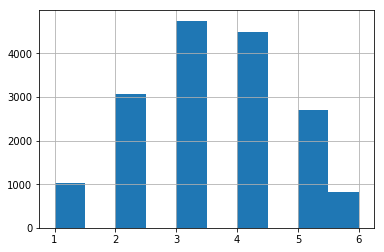

In [62]:
#offer received per person in transactional records
print(transcript_processed[(transcript_processed['event']=='offer viewed')].groupby('person')['event'].count().head())
transcript_processed[(transcript_processed['event']=='offer viewed')].groupby('person')['event'].count().hist();

In [63]:
#get count of offers received per person , put into separate datase
df_offer_received_cnt = transcript_processed[(transcript_processed['event']=='offer viewed')].groupby(['person','offer_id','time']).count()['event'].reset_index()
#rename columns
df_offer_received_cnt.rename(columns={'event':'offer_received_cnt'},inplace=True)

df_offer_received_cnt.drop(['time'], axis=1, inplace=True)
#ensure only unique person-offer_ids pair
df_offer_received_cnt= df_offer_received_cnt.groupby(['person','offer_id']).sum().reset_index()


Subract transactions not related to offer

In [64]:
#filter invalid transactions
transactions_not_related = transcript_processed[(transcript_processed['event']=='transaction') & (transcript_processed['completed_offer']==0)].groupby(['person','offer_id'])['amount'].sum().reset_index()
transactions_not_related.rename(columns={'amount':'amount_invalid'},inplace=True)

In [65]:
offers_bogo.head()

,person,offer_id,effective_offer,age,gender,income,membership_days
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,O,57000.0,39.0
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,F,90000.0,824.0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,F,60000.0,1071.0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,F,60000.0,1071.0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,F,74000.0,158.0


# Preparing data for implementation

- Merge with temporary datasets created above to include engineered features
- Drop missing values in gender, income , age
- Separate channel column into categorical values
- Treatement of duplicate records

In [66]:
#merge to get offers received count and invalid amount transaction
offers_bogo=offers_bogo.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']], how='left',on=['person','offer_id'])
offers_bogo=offers_bogo.merge(transactions_not_related[['person','offer_id','amount_invalid']], how='left',on=['person','offer_id'])

In [67]:
#check %age of missing values
(offers_bogo.isnull().sum()/len(offers_bogo)*100).sort_values(ascending = False).head()

amount_invalid        96.323752
income                 7.057489
gender                 7.057489
offer_received_cnt     1.172466
membership_days        0.000000
dtype: float64

In [68]:
#fill missing values for amount_invalid with 0
offers_bogo['amount_invalid']=offers_bogo['amount_invalid'].fillna(value=0)
offers_bogo.dropna(inplace=True)

In [69]:
#dummy variable encoding function
def dummy(df,col):
    df=pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df=df.drop(columns=col,axis=1,inplace=False)
    return df

In [70]:
#merge with portfolio to get offer details
offers_bogo=offers_bogo.merge(portfolio, how='left',on='offer_id')
#convert channel into categorical variables
for index,row in offers_bogo.iterrows():
    for channel in ['web','email','social','mobile']:
        if channel in offers_bogo.loc[index,'channels']:
            offers_bogo.loc[index,channel]=1
        else:
            offers_bogo.loc[index,channel]=0

In [71]:
offers_bogo= offers_bogo.drop(['channels'], axis=1, inplace=False)
#convert gender into categorical variables
offers_bogo = dummy(offers_bogo,'gender')

In [72]:
offers_bogo.head()

,person,offer_id,effective_offer,age,income,membership_days,offer_received_cnt,amount_invalid,difficulty,duration,offer_type,reward,web,email,social,mobile,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,57000.0,39.0,1.0,0.0,5,7,bogo,5,1.0,1.0,0.0,1.0,0,0,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,90000.0,824.0,1.0,0.0,10,5,bogo,10,1.0,1.0,1.0,1.0,1,0,0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,60000.0,1071.0,1.0,0.0,5,7,bogo,5,1.0,1.0,0.0,1.0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,60000.0,1071.0,1.0,0.0,5,5,bogo,5,1.0,1.0,1.0,1.0,1,0,0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,74000.0,158.0,1.0,0.0,5,5,bogo,5,1.0,1.0,1.0,1.0,1,0,0


In [73]:
def prep_offers_df(df):
    '''
    INPUT: 
    df - Original dataframe for modeling
    
    OUTPUT:
    Returns dataframe containing engineered features , filled missing values and cleaned and transformed variables
    '''
    #merge to get engineered features
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']], how='left',on=['person','offer_id'])
    df=df.merge(transactions_not_related[['person','offer_id','amount_invalid']], how='left',on=['person','offer_id'])
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)
    df.dropna(inplace=True);
    #merge with portfolio to get offer details
    df=df.merge(portfolio, how='left',on='offer_id')
    #convert channel into categorical variables
    for index,row in df.iterrows():
        for channel in ['web','email','social','mobile']:
            if channel in df.loc[index,'channels']:
                df.loc[index,channel]=1
            else:
                df.loc[index,channel]=0
    df= df.drop(['channels'], axis=1, inplace=False)
    df=dummy(df,'gender')
    
    return df
        

In [74]:
#prepare data for offer discounts
offers_discount = prep_offers_df(offers_discount)
offers_discount.head()

,person,offer_id,effective_offer,age,income,membership_days,offer_received_cnt,amount_invalid,difficulty,duration,offer_type,reward,web,email,social,mobile,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40,57000.0,39.0,1.0,0.0,20,10,discount,5,1.0,1.0,0.0,0.0,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40,57000.0,39.0,1.0,0.0,7,7,discount,3,1.0,1.0,1.0,1.0,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,59,90000.0,824.0,1.0,0.0,10,10,discount,2,1.0,1.0,1.0,1.0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,24,60000.0,1071.0,1.0,0.0,7,7,discount,3,1.0,1.0,1.0,1.0,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,26,73000.0,566.0,2.0,0.0,10,10,discount,2,1.0,1.0,1.0,1.0,1,0,0


In [75]:
#merge with portfolio to get offer details
offers_info=offers_info.merge(portfolio, how='left',on='offer_id')
#reset index for offer info
offers_info = offers_info.reset_index().drop(['index'],axis=1,inplace=False)
#convert channel into categorical
for index,row in offers_info.iterrows():
    for channel in ['web','email','social','mobile']:
        if channel in offers_info.loc[index,'channels']:
            offers_info.loc[index,channel]=1
        else:
            offers_info.loc[index,channel]=0
offers_info= offers_info.drop(['channels'], axis=1, inplace=False)



In [76]:
#repurpose function for offer_info 
def prep_offers_df(df):
    '''
    INPUT: 
    df - Dataframe to be transformed
    
    OUTPUT:
    Returns dataframe containing engineered features , filled missing values and cleaned and transformed variables
    '''
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']], how='left',on=['person','offer_id'])
    df=df.merge(transactions_not_related[['person','offer_id','amount_invalid']], how='left',on=['person','offer_id'])
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)
    df.dropna(inplace=True);

    df=dummy(df,'gender')
    
    return df
        

In [77]:
offers_info=prep_offers_df(offers_info)
offers_info.head()

,person,offer_id,effective_offer,age,income,membership_days,difficulty,duration,offer_type,reward,web,email,social,mobile,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,0,4,informational,0,1.0,1.0,0.0,1.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,1071.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,0,4,informational,0,1.0,1.0,0.0,1.0,1.0,0.00,1,0,0


# Implementation

Our target feature is effective_order. Since we have 3 different offer types, so we will have 3 models. We will copare performance of simple decision tree classifier model with an ensemble random forest classifier model. Reason for tree based model selection is that we want interpretability of the model. Also, it predicts whether customer will respond to different types of offer or not. We also selected Random Forest as an alternate model to compare with base model. We will ensure dataset is balanced.

In [78]:
#check for class balance in dataset
print(offers_bogo[['person','effective_offer']].groupby('effective_offer').count()/len(offers_bogo))
print(offers_discount[['person','effective_offer']].groupby('effective_offer').count()/len(offers_discount))
print(offers_info[['person','effective_offer']].groupby('effective_offer').count()/len(offers_info))

                   person
effective_offer          
0                0.180058
1                0.819942
                   person
effective_offer          
0                0.138255
1                0.861745
                   person
effective_offer          
0                0.262529
1                0.737471


We can see clases are uneven but not too imbalanced such that it will cause problem. Hence, we will proceed.

Since the classes for all three models are imbalanced, I decided to implement both accuracy and F1 score as model evaluation metric. F1 score provides better sense of model performance compared to purely accuracy as it takes both false positives and false negatives in calculation. F1 gives more weightage to true positive.

## Model Implementation

First define target and feature variables

In [79]:
def data_prep(df,col_drop):
    '''
    INPUT: 
    df - Prepared dataframe for modeling
    
    OUTPUT:
    Returns 2 dataframe - features and traget dataframes
    '''
    target = df['effective_offer']
    features = df.drop(columns=col_drop, inplace=False, axis=1)
    return features, target

Split data into training and test datasets. Apply scaler to ensure data will be on same scale for training

In [80]:
def model_pipeline(features,target):
    '''
    INPUT: 
    - features and target dataframes
    
    OUTPUT:
    -Splits features and target dataframe to train  and test ets, performs feature scaling on both datasets
    '''
    X_train,X_test,y_train,y_test= train_test_split(features, target, test_size=0.20, random_state=42)
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train,y_test

Function to define model scores - F1 Score and accuracy as well as error

In [81]:
def train_predict(model,X_train,y_train,X_test,y_test):
    '''
    INPUT: 
    model - learning algorithm to be trained and predicted on 
    X_train -  features training set
    y_train - review_scores_rating training set
    X_test - features testing set
    y_test - review_scores_rating testing set

    '''
    results={}
    start=time()
    model=model.fit(X_train,y_train)
    end=time()
    results['train_time']=end-start
    #Get predictions on test set
    start=time()
    predictions_test=model.predict(X_test)
    predictions_train=model.predict(X_train)
    end=time()
    #calculate total prediction time
    results['pred_time']=end-start
    #add training accuracy to results
    results['training_score']=model.score(X_train,y_train)
    #add testing accuracy to results
    results['testing_score']=model.score(X_test,y_test)
    
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training Accuracy :%.4f" % results['training_score'])
    print("Test Accuracy :%.4f" % results['testing_score'])
    print(classification_report(y_test,predictions_test,digits=4))
    return results   

In [82]:
def run_model(clf1,clf2,name):
    '''
    INPUT: 
    - clf1: first classifier model
    - clf2: second classifier model
    - name: name of models for comparison
    OUTPUT:
    -Dataframe of results from model training and prediction
    '''
    results = {}
    for clf in [clf1,clf2]:
        clf_name = clf.__class__.__name__+'_'+name
        results[clf_name]={}
        results[clf_name]=train_predict(clf,X_train,y_train, X_test, y_test)
    return pd.DataFrame(results)

BOGO Offers model

We will build BOGO offers model. Initialize the model with some randomly chosen parameters to check initial performance. If performance needs to be improved we will attempt GridSearch

In [83]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target = data_prep(offers_bogo,drop_cols_prep)
X_train,X_test,y_train,y_test = model_pipeline(features,target)
#Initialize the model - Baseline is decision tree model, bogo_1 model is RF Model
baseline = DecisionTreeClassifier(criterion='entropy' ,max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
bogo_1 = RandomForestClassifier(random_state=2,max_depth=11,max_features='auto',min_samples_split=10, n_estimators=20,
                                min_samples_leaf=20)

results = run_model(baseline,bogo_1,'bogo_1')

DecisionTreeClassifier trained on 9708 samples.
MSE_train: 0.1823
MSE_test: 0.1710
Training Accuracy :0.8177
Test Accuracy :0.8290
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       415
          1     0.8290    1.0000    0.9065      2012

avg / total     0.6873    0.8290    0.7515      2427

RandomForestClassifier trained on 9708 samples.
MSE_train: 0.1678
MSE_test: 0.1648
Training Accuracy :0.8322
Test Accuracy :0.8352
             precision    recall  f1-score   support

          0     0.6087    0.1012    0.1736       415
          1     0.8418    0.9866    0.9085      2012

avg / total     0.8020    0.8352    0.7828      2427



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of random forest outperforms decision tree model but overall accuracy is almost same of both models. In terms of F1 - Score both the models are below 80% with RF better than DT.

Discount offer model

Repeat same steps with my offer_discount dataset

In [84]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target = data_prep(offers_discount,drop_cols_prep)
X_train,X_test,y_train,y_test = model_pipeline(features,target)
discount_1 = RandomForestClassifier(random_state=2,max_depth=20,max_features='auto',min_samples_split=10, n_estimators=20,
                                    min_samples_leaf=10)

results = pd.concat([results[:],run_model(baseline,discount_1,'discount_1')],axis=1)

DecisionTreeClassifier trained on 9958 samples.
MSE_train: 0.1391
MSE_test: 0.1349
Training Accuracy :0.8609
Test Accuracy :0.8651
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       336
          1     0.8651    1.0000    0.9276      2154

avg / total     0.7483    0.8651    0.8025      2490



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 9958 samples.
MSE_train: 0.1296
MSE_test: 0.1361
Training Accuracy :0.8704
Test Accuracy :0.8639
             precision    recall  f1-score   support

          0     0.4516    0.0417    0.0763       336
          1     0.8691    0.9921    0.9265      2154

avg / total     0.8127    0.8639    0.8118      2490



Decision tree performed better that Random Forest in terms of accuracy (86.51% > 86.39%) and F1- score is also lower (80.25% < 81.18%)

Information Offer Model

In [85]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target = data_prep(offers_info,drop_cols_prep)
X_train,X_test,y_train,y_test = model_pipeline(features,target)
info_1 = RandomForestClassifier(random_state=5,criterion= 'gini',max_depth=20,max_features='auto',min_samples_split=10, 
                                n_estimators=20,min_samples_leaf=10)

results = pd.concat([results[:],run_model(baseline,info_1,'info_1')],axis=1)

DecisionTreeClassifier trained on 5555 samples.
MSE_train: 0.2560
MSE_test: 0.2268
Training Accuracy :0.7440
Test Accuracy :0.7732
             precision    recall  f1-score   support

          0     0.6164    0.1355    0.2222       332
          1     0.7819    0.9735    0.8673      1057

avg / total     0.7424    0.7732    0.7131      1389

RandomForestClassifier trained on 5555 samples.
MSE_train: 0.2353
MSE_test: 0.2196
Training Accuracy :0.7647
Test Accuracy :0.7804
             precision    recall  f1-score   support

          0     0.6421    0.1837    0.2857       332
          1     0.7906    0.9678    0.8703      1057

avg / total     0.7551    0.7804    0.7305      1389



Accuracy is below 80% but RF model is still performing better. F1 score is also bad for both.

# Refinement

We will first do parameter tuning for 3 RF models.

In [86]:
def best_model(offer_type):
    '''
    INPUT: 
    - offer_type: string of offer type name

    OUTPUT:
    -Dataframe containing results of best model so far
    '''
    print('For '+ offer_type+ ' RF model:')
    return results.transpose()[results.transpose()['testing_score']==results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]

Grid Search to find optimal parameters

In [87]:
def rand_forest_param_selection(X,y):
    param_grid = {'max_features': ['auto','sqrt'],
                  'max_depth':[5,10,15,20],
                  'n_estimators':[25,30,40,50],
                  'min_samples_split':[2,10,20],
                  'min_samples_leaf':[2,10,15,20],
        
        
    }
    
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2),param_grid)
    grid_search.fit(X,y)
    grid_search.best_params_
    return grid_search.best_params_

In [88]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target = data_prep(offers_info,drop_cols_prep)
X_train,X_test,y_train,y_test = model_pipeline(features,target)

rand_forest_param_selection(X_train, y_train)


{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 30}

Now we have optimal parameters , we will run model again with new parameters.

In [89]:
features,target = data_prep(offers_bogo,drop_cols_prep)
X_train,X_test,y_train,y_test = model_pipeline(features,target)
bogo_2 = RandomForestClassifier(random_state=2,max_depth=10,max_features='auto',min_samples_split=20, n_estimators=25,min_samples_leaf=2)

results = pd.concat([results[:],run_model(baseline,bogo_2,'bogo_2')],axis=1)

DecisionTreeClassifier trained on 9708 samples.
MSE_train: 0.1823
MSE_test: 0.1710
Training Accuracy :0.8177
Test Accuracy :0.8290
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       415
          1     0.8290    1.0000    0.9065      2012

avg / total     0.6873    0.8290    0.7515      2427



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 9708 samples.
MSE_train: 0.1545
MSE_test: 0.1636
Training Accuracy :0.8455
Test Accuracy :0.8364
             precision    recall  f1-score   support

          0     0.5978    0.1325    0.2170       415
          1     0.8458    0.9816    0.9087      2012

avg / total     0.8034    0.8364    0.7904      2427



In [90]:
results[['RandomForestClassifier_bogo_1','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
pred_time,0.029204,0.045573
testing_score,0.835187,0.836424
train_time,0.131856,0.175305
training_score,0.832200,0.845488


In [91]:
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.045573,0.836424,0.175305,0.845488


In [92]:
features,target = data_prep(offers_discount,drop_cols_prep)
X_train,X_test,y_train,y_test = model_pipeline(features,target)

rand_forest_param_selection(X_train,y_train)


{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 40}

In [93]:
X_train,X_test,y_train,y_test = model_pipeline(features,target)
discount_2 = RandomForestClassifier(random_state=2,max_depth=10,max_features='auto',min_samples_split=2, n_estimators=30,min_samples_leaf=2)

results = pd.concat([results[:],run_model(baseline,discount_2,'discount_2')],axis=1)

DecisionTreeClassifier trained on 9958 samples.
MSE_train: 0.1391
MSE_test: 0.1349
Training Accuracy :0.8609
Test Accuracy :0.8651
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       336
          1     0.8651    1.0000    0.9276      2154

avg / total     0.7483    0.8651    0.8025      2490



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 9958 samples.
MSE_train: 0.1282
MSE_test: 0.1337
Training Accuracy :0.8718
Test Accuracy :0.8663
             precision    recall  f1-score   support

          0     0.5556    0.0446    0.0826       336
          1     0.8697    0.9944    0.9279      2154

avg / total     0.8273    0.8663    0.8138      2490



In [94]:
results[['RandomForestClassifier_discount_1','RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
pred_time,0.033329,0.046658
testing_score,0.863855,0.866265
train_time,0.154906,0.218956
training_score,0.870355,0.871761


In [95]:
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.046658,0.866265,0.218956,0.871761


In [96]:
features,target = data_prep(offers_info,drop_cols_prep)
X_train,X_test,y_train,y_test = model_pipeline(features,target)
rand_forest_param_selection(X_train,y_train)


{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 30}

In [97]:
features,target = data_prep(offers_info,drop_cols_prep)
X_train,X_test,y_train,y_test = model_pipeline(features,target)
info_2 = RandomForestClassifier(random_state=2,max_depth=15,max_features='auto',min_samples_split=2, n_estimators=25,min_samples_leaf=20)

results = pd.concat([results[:],run_model(baseline,info_2,'info_2')],axis=1)

DecisionTreeClassifier trained on 5555 samples.
MSE_train: 0.2560
MSE_test: 0.2268
Training Accuracy :0.7440
Test Accuracy :0.7732
             precision    recall  f1-score   support

          0     0.6164    0.1355    0.2222       332
          1     0.7819    0.9735    0.8673      1057

avg / total     0.7424    0.7732    0.7131      1389

RandomForestClassifier trained on 5555 samples.
MSE_train: 0.2526
MSE_test: 0.2261
Training Accuracy :0.7474
Test Accuracy :0.7739
             precision    recall  f1-score   support

          0     0.6800    0.1024    0.1780       332
          1     0.7774    0.9849    0.8689      1057

avg / total     0.7542    0.7739    0.7038      1389



In [98]:
results[['RandomForestClassifier_info_1','RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
pred_time,0.018856,0.021831
testing_score,0.780418,0.773938
train_time,0.091042,0.104615
training_score,0.764716,0.747435


In [99]:
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_1,0.018856,0.780418,0.091042,0.764716


In [100]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']
features,target = data_prep(offers_bogo,drop_cols_prep)
X_train,X_test,y_train,y_test = model_pipeline(features,target)
bogo_3 = RandomForestClassifier(random_state=2,max_depth=10,max_features='auto',min_samples_split=20, n_estimators=25,min_samples_leaf=2)

results = pd.concat([results[:],run_model(baseline,bogo_3,'bogo_3')],axis=1)

DecisionTreeClassifier trained on 9708 samples.
MSE_train: 0.1784
MSE_test: 0.1706
Training Accuracy :0.8216
Test Accuracy :0.8294
             precision    recall  f1-score   support

          0     0.5034    0.1807    0.2660       415
          1     0.8507    0.9632    0.9035      2012

avg / total     0.7913    0.8294    0.7945      2427

RandomForestClassifier trained on 9708 samples.
MSE_train: 0.1535
MSE_test: 0.1706
Training Accuracy :0.8465
Test Accuracy :0.8294
             precision    recall  f1-score   support

          0     0.5044    0.1373    0.2159       415
          1     0.8453    0.9722    0.9043      2012

avg / total     0.7870    0.8294    0.7866      2427



In [101]:
results[['RandomForestClassifier_bogo_2','RandomForestClassifier_bogo_3']]

,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_3
pred_time,0.045573,0.039453
testing_score,0.836424,0.829419
train_time,0.175305,0.171651
training_score,0.845488,0.846518


In [102]:
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.045573,0.836424,0.175305,0.845488


In [103]:
features,target = data_prep(offers_discount,drop_cols_prep)
X_train,X_test,y_train,y_test = model_pipeline(features,target)
discount_3 = RandomForestClassifier(random_state=2,max_depth=10,max_features='auto',min_samples_split=2, n_estimators=30,min_samples_leaf=2)

results = pd.concat([results[:],run_model(baseline,discount_3,'discount_3')],axis=1)

DecisionTreeClassifier trained on 9958 samples.
MSE_train: 0.1391
MSE_test: 0.1349
Training Accuracy :0.8609
Test Accuracy :0.8651
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       336
          1     0.8651    1.0000    0.9276      2154

avg / total     0.7483    0.8651    0.8025      2490



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 9958 samples.
MSE_train: 0.1253
MSE_test: 0.1361
Training Accuracy :0.8747
Test Accuracy :0.8639
             precision    recall  f1-score   support

          0     0.4444    0.0357    0.0661       336
          1     0.8685    0.9930    0.9266      2154

avg / total     0.8112    0.8639    0.8105      2490



In [104]:
results[['RandomForestClassifier_discount_2','RandomForestClassifier_discount_3']]

,RandomForestClassifier_discount_2,RandomForestClassifier_discount_3
pred_time,0.046658,0.045734
testing_score,0.866265,0.863855
train_time,0.218956,0.236843
training_score,0.871761,0.874674


In [105]:
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.046658,0.866265,0.218956,0.871761


In [106]:
features,target = data_prep(offers_info,drop_cols_prep)
X_train,X_test,y_train,y_test = model_pipeline(features,target)
info_3 = RandomForestClassifier(random_state=2,max_depth=15,max_features='auto',min_samples_split=2, n_estimators=25,min_samples_leaf=20)

results = pd.concat([results[:],run_model(baseline,info_3,'info_3')],axis=1)

DecisionTreeClassifier trained on 5555 samples.
MSE_train: 0.2560
MSE_test: 0.2268
Training Accuracy :0.7440
Test Accuracy :0.7732
             precision    recall  f1-score   support

          0     0.6164    0.1355    0.2222       332
          1     0.7819    0.9735    0.8673      1057

avg / total     0.7424    0.7732    0.7131      1389

RandomForestClassifier trained on 5555 samples.
MSE_train: 0.2502
MSE_test: 0.2246
Training Accuracy :0.7498
Test Accuracy :0.7754
             precision    recall  f1-score   support

          0     0.6667    0.1205    0.2041       332
          1     0.7803    0.9811    0.8692      1057

avg / total     0.7531    0.7754    0.7103      1389



In [107]:
results[['RandomForestClassifier_info_2','RandomForestClassifier_info_3']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_3
pred_time,0.021831,0.021905
testing_score,0.773938,0.775378
train_time,0.104615,0.109731
training_score,0.747435,0.749775


In [108]:
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_1,0.018856,0.780418,0.091042,0.764716


In [109]:
best_model('bogo').append([best_model('discount'),best_model('info')]).transpose()

For bogo RF model:
For discount RF model:
For info RF model:


,RandomForestClassifier_bogo_2,RandomForestClassifier_discount_2,RandomForestClassifier_info_1
pred_time,0.045573,0.046658,0.018856
testing_score,0.836424,0.866265,0.780418
train_time,0.175305,0.218956,0.091042
training_score,0.845488,0.871761,0.764716


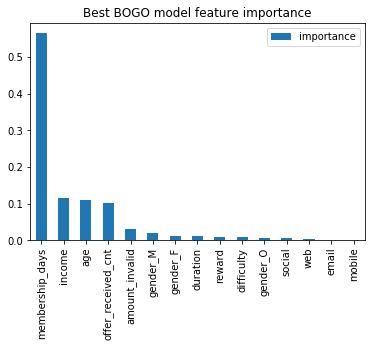

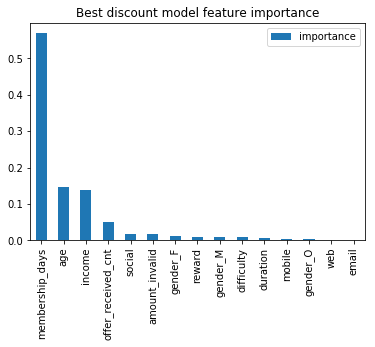

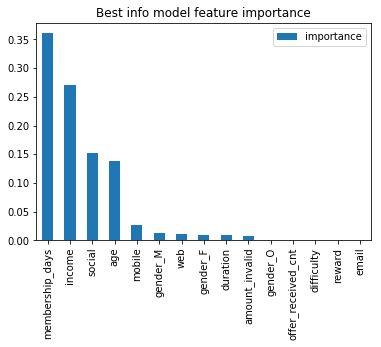

In [110]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target = data_prep(offers_bogo,drop_cols_prep)
feature_importances = pd.DataFrame(bogo_2.feature_importances_,index=features.columns,columns=['importance']).sort_values('importance',ascending=False)

feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

feature_importances = pd.DataFrame(discount_2.feature_importances_,index=features.columns,columns=['importance']).sort_values('importance',ascending=False)

feature_importances.plot.bar()
plt.title('Best discount model feature importance')
plt.show()

drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target = data_prep(offers_discount,drop_cols_prep)
feature_importances = pd.DataFrame(info_2.feature_importances_,index=features.columns,columns=['importance']).sort_values('importance',ascending=False)

feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()



In [111]:
results

,DecisionTreeClassifier_bogo_1,RandomForestClassifier_bogo_1,DecisionTreeClassifier_discount_1,RandomForestClassifier_discount_1,DecisionTreeClassifier_info_1,RandomForestClassifier_info_1,DecisionTreeClassifier_bogo_2,RandomForestClassifier_bogo_2,DecisionTreeClassifier_discount_2,RandomForestClassifier_discount_2,DecisionTreeClassifier_info_2,RandomForestClassifier_info_2,DecisionTreeClassifier_bogo_3,RandomForestClassifier_bogo_3,DecisionTreeClassifier_discount_3,RandomForestClassifier_discount_3,DecisionTreeClassifier_info_3,RandomForestClassifier_info_3
pred_time,0.001179,0.029204,0.001030,0.033329,0.000612,0.018856,0.001009,0.045573,0.001046,0.046658,0.000575,0.021831,0.001152,0.039453,0.001063,0.045734,0.000778,0.021905
testing_score,0.829007,0.835187,0.865060,0.863855,0.773218,0.780418,0.829007,0.836424,0.865060,0.866265,0.773218,0.773938,0.829419,0.829419,0.865060,0.863855,0.773218,0.775378
train_time,0.025569,0.131856,0.018280,0.154906,0.009592,0.091042,0.016425,0.175305,0.017584,0.218956,0.009267,0.104615,0.017298,0.171651,0.018606,0.236843,0.010358,0.109731
training_score,0.817676,0.832200,0.860916,0.870355,0.744014,0.764716,0.817676,0.845488,0.860916,0.871761,0.744014,0.747435,0.821590,0.846518,0.860916,0.874674,0.744014,0.749775


Conclusion:

This project was challenging due to transcript dataset. Started with 2 questions:
- What are main features influencing effectiveness of an offer
- Can the data predict whether user can take up offer?